# Explore here

In [1]:
import pandas as pd
from pathlib import Path
import zipfile, os
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
import joblib
warnings.filterwarnings('ignore')

In [2]:
#Ubicamos modelo
#Indicamos cuál es la carpeta en directorio (src)
BASE_DIR = Path().resolve()

#Indicamos la ruta del modelo
MODEL_PATH = BASE_DIR.parent / "models" / "xgb_model.pkl"

print(MODEL_PATH)
print(MODEL_PATH.exists())  #Comprobamos que el modelo existe = true

/workspaces/equipoEnergias_XGB_con_Streamlit/models/xgb_model.pkl
True


In [3]:
#Cargamos modelo
MODEL_PATH = "../models/xgb_model.pkl"
model = joblib.load(MODEL_PATH)
print("El modelo se ha cargado correctamente ✅")

El modelo se ha cargado correctamente ✅


In [4]:
#Sacamos las categorias usadas del modelo
print(model.feature_names_in_)

['demanda_lag_1' 'demanda_lag_24' 'demanda_lag_168' 'media_movil_24h'
 'hora' 'mes' 'es_finde' 'dia_semana' 'Madrid_temperature_2m'
 'Valencia_temperature_2m' 'Pais_Vasco_temperature_2m'
 'Cataluna_temperature_2m' 'Andalucia_temperature_2m']


In [5]:
#Probamos a predecir
X_test = pd.DataFrame([{
    "demanda_lag_1": 28000,
    "demanda_lag_24": 27500,
    "demanda_lag_168": 26000,
    "media_movil_24h": 27000,
    "hora": 18,
    "mes": 1,
    "es_finde": 0,
    "dia_semana": 2,
    "Madrid_temperature_2m": 30.5,
    "Valencia_temperature_2m": 29.0,
    "Pais_Vasco_temperature_2m": 22.0,
    "Cataluna_temperature_2m": 28.0,
    "Andalucia_temperature_2m": 33.0
}])

X_test = X_test[model.feature_names_in_]
pred = model.predict(X_test)
print("Predicción de demanda eléctrica (MW):", pred[0])

Predicción de demanda eléctrica (MW): 28347.047


In [6]:
#para el error de DATABASE_URL
def db_connect():
    db_url = os.getenv("DATABASE_URL")

    if not db_url:
        return None  # ← evita el crash

    engine = create_engine(db_url)
    return engine

In [7]:
print("Columnas que espera el modelo:")
print(model.feature_names_in_)

Columnas que espera el modelo:
['demanda_lag_1' 'demanda_lag_24' 'demanda_lag_168' 'media_movil_24h'
 'hora' 'mes' 'es_finde' 'dia_semana' 'Madrid_temperature_2m'
 'Valencia_temperature_2m' 'Pais_Vasco_temperature_2m'
 'Cataluna_temperature_2m' 'Andalucia_temperature_2m']


AÑADIMOS EL DATASET DE CONSULTA Y REVISAMOS

In [8]:
# -----------------------------
# Ruta del dataset
# -----------------------------
ruta_dataset = "/workspaces/equipoEnergias_XGB_con_Streamlit/data/processed/dataset_consulta.csv"

# -----------------------------
# Leer el CSV
# -----------------------------
df = pd.read_csv(ruta_dataset)

# -----------------------------
# Primer vistazo a los datos
# -----------------------------
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
print(df.head())

print("\nTipos de datos:")
print(df.dtypes)

print("\nValores nulos por columna:")
print(df.isnull().sum())


Dimensiones del dataset: (78911, 6)

Primeras filas:
                       fecha  year  mes  hora  es_finde  demanda_real
0  2016-01-01 00:00:00+00:00  2016  1.0   0.0       0.0  21745.166667
1  2016-01-01 01:00:00+00:00  2016  1.0   1.0       0.0  20483.333333
2  2016-01-01 02:00:00+00:00  2016  1.0   2.0       0.0  19246.333333
3  2016-01-01 03:00:00+00:00  2016  1.0   3.0       0.0  18358.166667
4  2016-01-01 04:00:00+00:00  2016  1.0   4.0       0.0  18057.333333

Tipos de datos:
fecha            object
year              int64
mes             float64
hora            float64
es_finde        float64
demanda_real    float64
dtype: object

Valores nulos por columna:
fecha           0
year            0
mes             0
hora            0
es_finde        0
demanda_real    0
dtype: int64


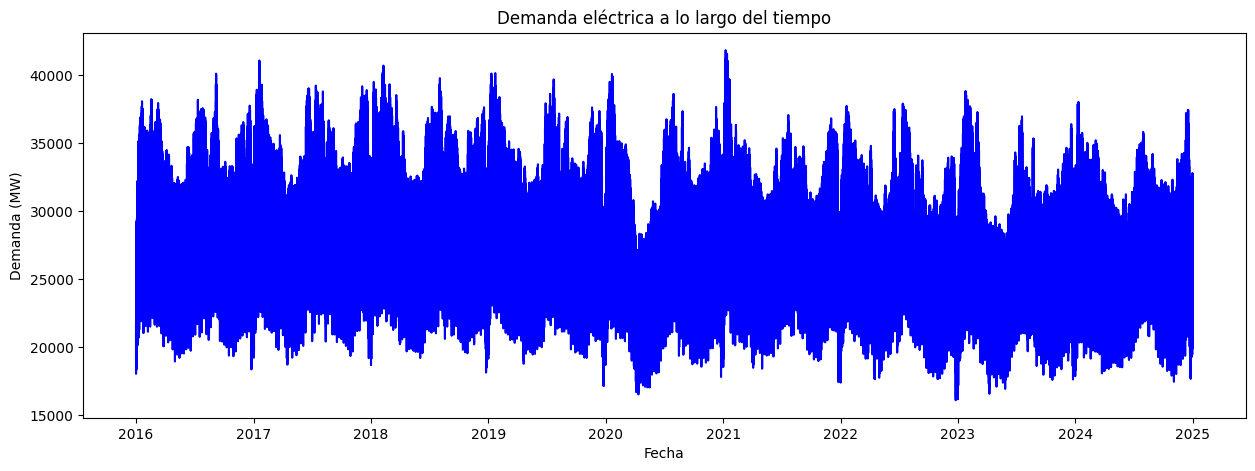

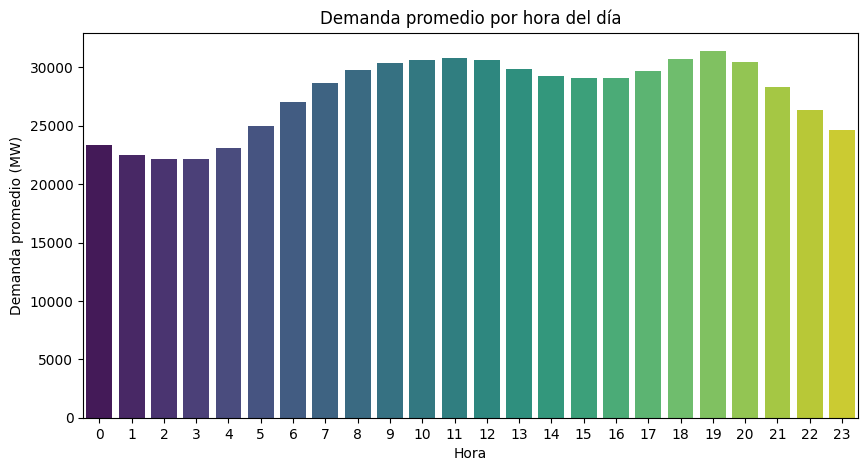

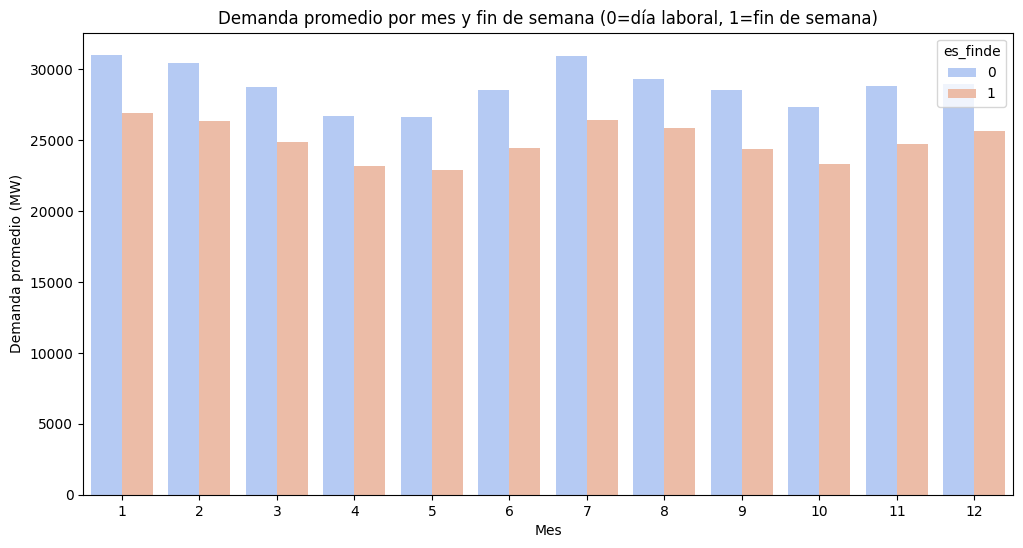

In [9]:
# -----------------------------
# Leer y preparar dataset
# -----------------------------
df = pd.read_csv("/workspaces/equipoEnergias_XGB_con_Streamlit/data/processed/dataset_consulta.csv")
df['fecha'] = pd.to_datetime(df['fecha'])
df['mes'] = df['mes'].astype(int)
df['hora'] = df['hora'].astype(int)
df['es_finde'] = df['es_finde'].astype(int)

# -----------------------------
# Gráfico 1: Demanda a lo largo del tiempo
# -----------------------------
plt.figure(figsize=(15,5))
plt.plot(df['fecha'], df['demanda_real'], color='blue')
plt.title("Demanda eléctrica a lo largo del tiempo")
plt.xlabel("Fecha")
plt.ylabel("Demanda (MW)")
plt.show()

# -----------------------------
# Gráfico 2: Demanda promedio por hora del día
# -----------------------------
demanda_por_hora = df.groupby('hora')['demanda_real'].mean()
plt.figure(figsize=(10,5))
sns.barplot(x=demanda_por_hora.index, y=demanda_por_hora.values, palette="viridis")
plt.title("Demanda promedio por hora del día")
plt.xlabel("Hora")
plt.ylabel("Demanda promedio (MW)")
plt.show()

# -----------------------------
# Gráfico 3: Demanda promedio por mes y fin de semana
# -----------------------------
demanda_mes_finde = df.groupby(['mes', 'es_finde'])['demanda_real'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(data=demanda_mes_finde, x='mes', y='demanda_real', hue='es_finde', palette="coolwarm")
plt.title("Demanda promedio por mes y fin de semana (0=día laboral, 1=fin de semana)")
plt.xlabel("Mes")
plt.ylabel("Demanda promedio (MW)")
plt.show()

In [10]:
# --- 1. Definir rutas ---
DATA_PATH = Path("/workspaces/equipoEnergias_XGB_con_Streamlit/data/processed/dataset_consulta.csv")
MODEL_PATH = Path("/workspaces/equipoEnergias_XGB_con_Streamlit/models/xgb_model.pkl")

# --- 2. Cargar dataset ---
df = pd.read_csv(DATA_PATH, parse_dates=["fecha"])
print("Dimensiones del dataset:", df.shape)

# --- 3. Crear columnas necesarias ---
df = df.sort_values("fecha")  # importante para lags y media móvil
df["dia_semana"] = df["fecha"].dt.dayofweek  # lunes=0, domingo=6
df["demanda_lag_1"] = df["demanda_real"].shift(1)
df["demanda_lag_24"] = df["demanda_real"].shift(24)
df["demanda_lag_168"] = df["demanda_real"].shift(168)
df["media_movil_24h"] = df["demanda_real"].rolling(window=24).mean()

# --- 4. Añadir columnas de temperatura con 0 ---
for col in ['Madrid_temperature_2m', 'Valencia_temperature_2m', 
            'Pais_Vasco_temperature_2m', 'Cataluna_temperature_2m', 
            'Andalucia_temperature_2m']:
    df[col] = 0

# --- 5. Cargar modelo ---
model = joblib.load(MODEL_PATH)
print("Modelo cargado ✅")
features = model.feature_names_in_

# --- 6. Filtrar filas con valores completos para las features ---
df_pred = df.dropna(subset=features).copy()

# --- 7. Predecir ---
df_pred["demanda_pred"] = model.predict(df_pred[features])

# --- 8. Mostrar resultados ---
print(df_pred[["fecha", "demanda_real", "demanda_pred"]].head(10))


Dimensiones del dataset: (78911, 6)
Modelo cargado ✅


                        fecha  demanda_real  demanda_pred
168 2016-01-08 00:00:00+00:00  25346.333333  25804.691406
169 2016-01-08 01:00:00+00:00  24059.166667  23775.775391
170 2016-01-08 02:00:00+00:00  23255.333333  23328.824219
171 2016-01-08 03:00:00+00:00  22846.000000  22903.791016
172 2016-01-08 04:00:00+00:00  23326.500000  23251.623047
173 2016-01-08 05:00:00+00:00  25388.166667  25124.314453
174 2016-01-08 06:00:00+00:00  29114.500000  29434.810547
175 2016-01-08 07:00:00+00:00  31964.666667  32874.964844
176 2016-01-08 08:00:00+00:00  32919.166667  34503.496094
177 2016-01-08 09:00:00+00:00  33591.166667  34713.800781


MAE: 704.78 MW
RMSE: 897.57 MW


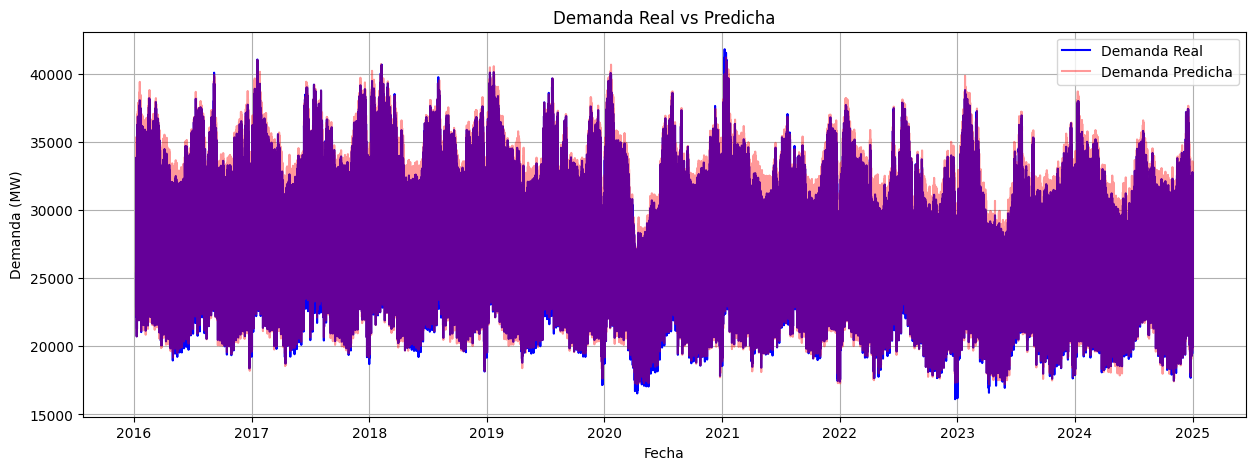

In [11]:
# --- 1. Calcular métricas de error ---
mae = mean_absolute_error(df_pred["demanda_real"], df_pred["demanda_pred"])
rmse = np.sqrt(mean_squared_error(df_pred["demanda_real"], df_pred["demanda_pred"]))

print(f"MAE: {mae:.2f} MW")
print(f"RMSE: {rmse:.2f} MW")

# --- 2. Graficar demanda real vs predicha ---
plt.figure(figsize=(15,5))
plt.plot(df_pred["fecha"], df_pred["demanda_real"], label="Demanda Real", color="blue")
plt.plot(df_pred["fecha"], df_pred["demanda_pred"], label="Demanda Predicha", color="red", alpha=0.4)
plt.xlabel("Fecha")
plt.ylabel("Demanda (MW)")
plt.title("Demanda Real vs Predicha")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Definir dataset histórico
df_hist = df.copy()  # si ya cargaste df desde dataset_consulta.csv

# Mostrar todos los años únicos disponibles
print("Años disponibles en el dataset histórico:", df_hist["year"].unique())

# Contar cuántas filas hay por año
print(df_hist["year"].value_counts())


Años disponibles en el dataset histórico: [2016 2017 2018 2019 2020 2021 2022 2023 2024]
year
2016    8784
2020    8784
2024    8783
2018    8760
2017    8760
2019    8760
2021    8760
2022    8760
2023    8760
Name: count, dtype: int64


# -----------------------------
# PARTE 1: Inputs de demanda
# -----------------------------
st.title("Predicción de Demanda Eléctrica ⚡")
st.subheader("Introduce los valores")

def float_input_safe(label, ejemplo=27000):
    # Contenedor horizontal
    col_input, col_ej = st.columns([0.2, 0.4])

    with col_input:
        val_str = st.text_input(
            f"{label} (MW)", 
            value="", 
            max_chars=10,
            key=label,
            help=f"Ej. {ejemplo}"  # ahora la guía está en el tooltip de ayuda
        )

        # Conversión segura a float
        try:
            val_clean = float(val_str.replace(".", "").replace(",", "")) if val_str else ejemplo
        except:
            val_clean = ejemplo

    with col_ej:
        # Columna vacía, ya no necesitamos la leyenda fuera de la caja
        st.write("")

    return val_clean

demanda_lag_1 = float_input_safe("Demanda hace 1 hora")
demanda_lag_24 = float_input_safe("Demanda hace 24 horas")
demanda_lag_168 = float_input_safe("Demanda hace 168 horas")
media_movil_24h = float_input_safe("Media móvil 24h")


# -----------------------------
# Slider interactivo de hora con color fijo azul cobalto
# -----------------------------
col1, col2 = st.columns([2,1])

with col1:
    # Slider de hora
    hora_real = st.slider(
        "Hora del día",
        min_value=0,
        max_value=23,
        value=18,  # valor por defecto = 6 PM
        step=1
    )

icono = "☀️" if 6 <= hora_real <= 18 else "🌙"

st.markdown(f"""
<style>
div[data-baseweb="slider"] input[type="range"] {{
    accent-color: #0047AB;
}}
</style>
""", unsafe_allow_html=True)

st.markdown(f"<div style='margin-top:5px; margin-bottom:10px; color:#0047AB; font-weight:bold;'>Hora seleccionada: {hora_real}h {icono}</div>", unsafe_allow_html=True)


# -----------------------------
# Slider para el día de la semana
# -----------------------------

dias_semana_nombres = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

with col1:
    dia_semana = st.slider(
        "Día de la semana",
        min_value=1,
        max_value=7,
        value=3,  # Por defecto Miércoles
        step=1
    )

dia_nombre = dias_semana_nombres[dia_semana - 1]

es_finde_num = 1 if dia_semana in [6, 7] else 0
es_finde_texto = "Sí" if es_finde_num == 1 else "No"

st.markdown(f"<div style='margin-top:5px; margin-bottom:5px; font-weight:bold;'>Día seleccionado: {dia_nombre}</div>", unsafe_allow_html=True)
st.markdown(f"<div style='margin-bottom:10px;'>Es fin de semana: {es_finde_texto}</div>", unsafe_allow_html=True)


# -----------------------------
# MES + ESTACIÓN DEL AÑO
# -----------------------------

meses = {
    "Enero": 1,
    "Febrero": 2,
    "Marzo": 3,
    "Abril": 4,
    "Mayo": 5,
    "Junio": 6,
    "Julio": 7,
    "Agosto": 8,
    "Septiembre": 9,
    "Octubre": 10,
    "Noviembre": 11,
    "Diciembre": 12
}

col1, col2 = st.columns([0.2,0.4])
with col1:
    mes_nombre = st.selectbox("Mes", list(meses.keys()))
    mes = meses[mes_nombre]

if mes in [12, 1, 2]:
    estacion = "❄️ Invierno"
elif mes in [3, 4, 5]:
    estacion = "🌱 Primavera"
elif mes in [6, 7, 8]:
    estacion = "☀️ Verano"
else:
    estacion = "🍂 Otoño"

st.markdown(f"<div style='margin-top:5px; margin-bottom:15px; font-weight:bold;'>Estación del año: {estacion}</div>", unsafe_allow_html=True)


# -----------------------------
# TEMPERATURA SEGÚN REGIÓN
# -----------------------------
st.markdown("### 🌡️ Temperaturas por región")

temp_valores = list(range(-15, 49))

col1, col2, col3 = st.columns(3)

with col1:
    temp_mad = st.selectbox("Región Central (ºC)", temp_valores, index=temp_valores.index(30))
    temp_val = st.selectbox("Región Sureste (ºC)", temp_valores, index=temp_valores.index(29))

with col2:
    temp_pv = st.selectbox("Región Norte (ºC)", temp_valores, index=temp_valores.index(22))
    temp_cat = st.selectbox("Región Noreste (ºC)", temp_valores, index=temp_valores.index(28))

with col3:
    temp_and = st.selectbox("Región Sur (ºC)", temp_valores, index=temp_valores.index(33))


# -----------------------------
# DataFrame para el modelo
# -----------------------------
X_input = pd.DataFrame([{
    "demanda_lag_1": demanda_lag_1,
    "demanda_lag_24": demanda_lag_24,
    "demanda_lag_168": demanda_lag_168,
    "media_movil_24h": media_movil_24h,
    "hora": hora_real,
    "mes": mes,
    "es_finde": es_finde_num,
    "dia_semana": dia_semana,
    "Madrid_temperature_2m": temp_mad,
    "Valencia_temperature_2m": temp_val,
    "Pais_Vasco_temperature_2m": temp_pv,
    "Cataluna_temperature_2m": temp_cat,
    "Andalucia_temperature_2m": temp_and
}])

# -----------------------------
# Alineación con columnas del modelo
# -----------------------------
for col in model.feature_names_in_:
    if col not in X_input.columns:
        X_input[col] = 0.0
X_input = X_input[model.feature_names_in_]

# -----------------------------
# Predicción
# -----------------------------
if st.button("Calcular"):
    pred = model.predict(X_input)[0]
    st.success(f"📈 La predicción de demanda real es de **{pred:,.0f} MW**")

# -----------------------------
# SECCIÓN EDA
# -----------------------------
if seccion == "EDA":
    st.title("📊 Análisis Exploratorio de Datos (EDA)")
    st.info("inserte aquí verborrea y grafiquitos.")
